In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import math
from numba import jit
import statistics 
import scipy.stats as stats
from matplotlib.pyplot import figure
import imageio
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Zadanie polegało na symulacji firmy ubezpieczeniowej, która sprzedaje polisy OC i AC.

Zakładamy, że nasza firma zaczyna działać 1 stycznia z kapitałem początkowym $k_{0}$ równym 10000zł, n=20 sprzedanymi polisami OC, m=0 sprzedanymi polisami AC oraz nie mamy żadnego kredytu.
Już od pierwszego dnia działania naszej firmy zdobywamy klientów OC i AC, ale dopiero po miesiącu mogą oni zrezygnować z wykupionych polis. Pierwszego dnia każdego miesiąca można u nas wykupić polisy OC i AC lub z nich zrezygnować. Cena polisy OC wynosi 720zł rocznie, co daje w przeliczeniu 60zł miesięcznie, a cena polisy AC to 480zł rocznie, czyli 40zł miesięcznie. Nasz nakład na marketing jest zależny od kapitału i wynosi 10% naszego posiadanego kapitału. Z racji tego, że nasze ceny OC i AC są stosunkowo niskie w porównaniu do konkurencji, to popyt na nie jest duży i wynosi on 1000 zarówno na polisy OC jak i AC. Odszkodowania za szkody OC i AC wypłacamy codziennie, natomiast zysk i przychód liczymy miesięcznie. Do odprowadzanego podatku z zysku sumujemy koszty z całego miesiąca i odejmujemy je od przychodu. Jeśli nasz kapitał spadnie poniżej 0, możemy zaciągnąć kredyt w wysokości 120n (jeśli nie mamy żadnych zobowiązań). Kredyt spłacamy po 6 miesiącach w 20 ratach miesięcznych w wysokości 1/12 wziętego kredytu. Jeśli nasz kapitał pozostaje ujemny przez 2 lata to firma bankrutuje, również jeśli kapitał spadnie poniżej $-2k_{0}-n c_{ac}$ automatycznie bankrutujemy.

Parametr $ \lambda_{0} $ odpowiadający za częstotliwość występowania szkód w danym dniu dobraliśmy na podstawie rzeczywistych danych ze strony https://statystyka.policja.pl/st/ruch-drogowy/76562,wypadki-drogowe-raporty-roczne.html (wypadki drogowe 2020). $ \lambda_{0} $ dobraliśmy proporcjonalnie do danego dnia tygodnia i miesiąca (przykładowo współczynnik jest większy w piątek w lipcu niż w poniedziałek w kwietniu).

Spis dobranych przez nas parametrów: 

$k_{0}$ - kapitał początkowy - 10000zł <br>
$c_{oc}$ - cena OC - 60zł <br>
$c_{ac}$ - cena AC - 40zł<br>
$n$ - ilość sprzedanych polis OC <br>
$m$ - ilość sprzedanych polis AC <br>
$m_{oc}$ - popyt OC - 1000 <br>
$m_{ac}$ - popyt AC - 1000 <br>
$s_{oc}$ - stała popyt OC - 10 <br>
$M_{ac}$ - stała związana z ceną AC - 10 <br>
$ \mu $ - nakład na marketing - 10% z kapitału <br>
$n_{0}$ - ustalony parametr - 1/5 <br>
$\lambda_{w}$ - ustalony parametr - 500 <br>
$t_{V}$ - ustalony parametr - 0 <br>
przychód, zysk - miesięczne <br>
kapitał, koszty - dzienne <br>

In [29]:
def zmienna_N(n):
    """"
    Funkcja zwracająca wartość zmiennej losowej N, pochodzącej z rozkładu dyskretnego. 
    Args:
        n (int): liczba sprzedanych polis OC
    Returns:
        zmienna N
    """
    return random.choices([n, math.floor(0.9*n), math.floor(n/2)], [0.5, 0.3, 0.2])[0]

In [30]:
def zmienna_M(n, n0=1/5):
    """"
    Funkcja zwracająca wartość zmiennej losowej M, pochodzącej z rozkładu dyskretnego. 
    Args:
        n (int): liczba sprzedanych polis OC
        n0 (float): ustalony parametr
    Returns:
        zmienna M
    """
    return random.choices([n/2, n/3, n/5, n0], [0.1, 0.1, 0.4, 0.4])[0]

In [31]:
def rezygnacja_OC(n, c_oc, m_oc = 1000):
    """"
    Funkcja zwracająca zmienną z rozkładu dwumianowego odpowiadającą ilości klientów, 
    którzy zrezygnowali z zakupionej w naszej firmie polisy OC.
    Args:
        n (int): liczba sprzedanych polis OC
        c_oc (int): cena polisy OC
        m_oc (int): stała związana z popytem na polisy OC
    Returns:
        ilość klientów, którzy zrezygnowali z polisy OC
    """
    return np.random.binomial(zmienna_N(n), (c_oc/m_oc)**2.5)

In [32]:
def rezygnacja_AC(m, c_ac, m_ac = 1000):
    """"
    Funkcja zwracająca zmienną z rozkładu dwumianowego odpowiadającą ilości klientów, 
    którzy zrezygnowali z zakupionej w naszej firmie polisy AC.
    Args:
        m (int): liczba sprzedanych polis AC
        c_ac (int): cena polisy AC
        m_ac (int): stała związana z popytem na polisy AC
    Returns:
        ilość klientów, którzy zrezygnowali z polisy AC
    """
    z = np.random.normal()
    return np.random.binomial(m, abs(z) * c_ac/m_ac)

In [33]:
def nowe_polisy_OC(n, c_oc, k, s_oc = 10):
    """"
    Funkcja zwracająca zmienną z rozkładu Poissona odpowiadającą za ilość nowych klientów, 
    którzy wykupili polisy OC w naszej firmie.
    Args:
        n (int): liczba sprzedanych polis OC
        c_oc (int): cena polisy AC
    Returns:
        liczba nowych klientów
    """
    if k>0:
        mi=k/10
    else:
        mi=0
    return np.random.poisson(2*np.log(1 + mi * np.sqrt(zmienna_M(n)/c_oc) + s_oc/c_oc))

In [34]:
def nowe_polisy_AC(n, m, c_ac):
    """"
    Funkcja zwracająca zmienną z rozkładu dwumianowego odpowiadającą za ilość nowych klientów, 
    którzy wykupili polisy AC w naszej firmie.
    Args:
        n (int): liczba sprzedanych polis OC
        m (int): liczba sprzedanych polis AC
        c_ac (int): cena polisy AC
    Returns:
        liczba nowych klientów
    """
    return np.random.binomial(n, m/(n*c_ac))

In [35]:
def wzrost_kapital(n, m, c_oc, c_ac, k):
    """"
    Funkcja zwracająca wartość o jaką wzrasta co miesiąc nasz kapitał.
    Args:
        n (int): liczba sprzedanych polis OC
        m (int): liczba sprzedanych polis AC
        c_oc (int): cena polisy OC
        c_ac (int): cena polisy AC
        k (float): kapitał
    Returns:
        miesięczny przychód
    """
    if k>0:
        mi=k/10    #nakłady na marketing
    else:
        mi=0
    return n*c_oc + m*c_ac - mi

In [36]:
def lambd0(t): 
    """"
    Funkcja intensywności w procesie Poissona. Wartość lambda0 zmienia się w zależności od dnia tygodnia i miesiąca, 
    a w "typowy" dzien wynosi 1.
    Args:
        t (int): dzień
    Returns:
        wartość lambda0
    """
    d = t%7
    k = math.floor(t/360)  #rok od zerowego
    m = math.ceil(t/30) - 12*k

    if m==3 or m==11:
        intens = 0.8
    if m==4:
        intens = 0.7
    if m==7 or m==8 or m==9:
        intens = 1.2
    else:
        intens = 1

    if d==6:
        return 0.95*intens  #jeśli sobota 
    if d==0:
        return 0.76*intens  #jeśli niedziela
    if d==5:
        return 1.12*intens  #jeśli piątek
    else:   
        return 1.0*intens    #jeśli dzień powszedni zwykły

In [37]:
def lambd(t, n, lambd_w=500):
    """"
    Funkcja zwracająca intensywność sygnałów o szkodach z polisy OC, jakie pojawiają się w naszej firmie.
    Args:
        t (int): dzień
        n (int): liczba sprzedanych polis OC
        lambd_w (int): ustalony parametr
    Returns:
        intensywność sygnałów o szkodach
    """
    w = [np.random.exponential(1/lambd_w) * lambd0(t) for _ in range(n)]
    return sum(w)

In [53]:
def wielkosc_szkod_OC():
    """"
    Funkcja zwracająca wielkość szkody z polisy OC.
    """
    szkoda = np.random.pareto(0.5) + 500
    if szkoda > 20000:
        szkoda = 20000
    return round(szkoda)

In [54]:
def wyplata_koszty_OC(t, n, lambd_w = 500):
    """"
    Funkcja zwracająca koszty związane z wypłatami odszkodowań OC w danym dniu t.
    Args:
        t (int): dzień
        n (int): liczba sprzedanych polis OC
        lambd_w (int): ustalony parametr
    Returns:
        dzienny koszt
    """
    S = []
    v = 0
    koszty = 0
    zmienna = True
    l = lambd(t, n, lambd_w)
    if l > 0:
        while zmienna:
            U = np.random.uniform(0,1)
            v -= (1/l)*np.log(U)
            if v > 1:
                zmienna = False
            else:
                S.append(v)
    else:
        S = []
    for i in range(len(S)):
        koszty += wielkosc_szkod_OC()
    return koszty

In [55]:
def wielkosc_szkod_AC(c_ac, M_ac = 10):
    """"
    Funkcja zwracająca wielkość szkody z polisy AC.
    Args:
        c_ac (int): cena polisy AC
        M_ac (int): wielokrotność ceny polisy AC
    Returns:
        wielkość szkody 
    """
    return min(abs(100*np.random.standard_cauchy())/2, M_ac*c_ac)

In [56]:
def wyplata_koszty_AC(c_ac, tv=0):
    """"
    Funkcja zwracająca koszty związane z wypłatami odszkodowań AC  w danym dniu t.
    Args:
        c_ac (int): cena polisy AC
        tv (int): ustalony parametr
    Returns:
        dzienny koszt
    """
    S = []
    Sn = 0
    koszty = 0
    zmienna = True 
    while zmienna:
        czas = np.random.uniform(tv, tv + np.random.rayleigh(100/np.sqrt(np.pi/2)))
        Sn += czas
        if Sn > 1:
            zmienna = False
        else:
            S.append(Sn)
    for i in range(len(S)):
        koszty += wielkosc_szkod_AC(c_ac)
    return koszty

In [57]:
def symulacja_firma(T, k0 = 10000, n=20, m = 0, c_oc = 60, c_ac = 40):
    """"
    Funkcja zwracająca listę dziennych kapitałów w zakresie czasu do dnia T lub do momentu ruiny.
    Args:
        T (int): dzień, do którego ma trwać symulacja
        k0 (int): kapitał początkowy
        n (int): liczba sprzedanych polis OC
        m (int): liczba sprzedanych polis AC
        c_oc (int): cena polisy OC
        c_ac (int): cena polisy AC
    Returns:
        lista dziennych kapitałów
    """
    
    zmienna = True
    t = 1    #dzień pierwszy działania naszej firmy
    przychod = 0        
    koszty = 0
    koszt_OC = 0
    zysk = 0        
    kapital_lista = [k0]
    przychod_lista = []
    zysk_lista = []
    koszty_lista = []
    kredyt = False
    splata = False

    while t <= T and zmienna == True:    #pętla trwa do dnia T lub dopóki nie osiągniemy ruiny
        rok = math.floor(t/360)  #rok od zerowego
        miesiac = math.ceil(t/30) - 12*rok  #miesiąc od 1
        kapital = kapital_lista[-1]    

        #rezygnacja
        if t%30 == 1 and t!= 1:
            n-= rezygnacja_OC(n, c_oc)    #klienci mogą rezygnować na początku każdego miesiąca
            m-= rezygnacja_AC(m, c_ac)
        
        #nowi klienci i przychód
        if t%30 ==1:
            nowe_OC = nowe_polisy_OC(n, c_oc, kapital)    #nowych klientów zdobywamy na początku każdego miesiąca
            n+= nowe_OC
            nowe_AC = nowe_polisy_AC(n, m, c_ac)
            m+= nowe_AC
            przychod = wzrost_kapital(n, m, c_oc, c_ac, kapital)    #liczymy miesięczny przychód
            przychod_lista.append(przychod)
            kapital += przychod      #wzrost kapitału        
            
        #spłacamy kredyt w dniu miesiąca, w którym go wzięliśmy
        if kredyt == True and t%30 == data_kredytu_dzien:
            if t == data_kredytu + 180:
                splata = True       #zaczynamy spłacać kredyt po 6 miesiącach od dnia jego zaciągnięcia

            if t == data_kredytu  + 780: 
                splata = False      #kończymy spłacać kredyt
                kredyt = False

            if splata == True:
                kapital -= 1/12 * wartosc_kredytu    #20 rat miesięcznych po 1/12 wysokosci zaciągniętego kredytu

        #odejmujemy koszty
        koszt_OC = wyplata_koszty_OC(t, n)
        koszt_AC = wyplata_koszty_AC(c_ac)
        koszt_laczny = koszt_OC + koszt_AC
        koszty_lista.append(koszt_laczny)
        kapital -= koszt_laczny
        
        #liczymy miesięczny zysk
        if t%30 == 1:
            zysk = przychod - sum(koszty_lista[-1:30])    #odejmujemy od przychodu miesięcznego sumę kosztów z całego miesiąca
            zysk_lista.append(zysk)
            
        #płacimy podatek 30 kwietnia każdego roku
        if miesiac==4 and t%30==0 and rok>0:
            podatek = 0.3*sum(zysk_lista[-1:-12]) + 0.05*sum(przychod_lista[-1:-12]) + 0.04*kapital_lista[-1]
            kapital -= podatek
        
        #jeśli nasz kaptał spadnie poniżej 0
        if kapital < 0:
            mi = 0
            if splata == False and kredyt == False:    #możemy zaciągnąć kredyt jeśli nie mamy żadnych zobowiązań
                kredyt = True
                data_kredytu = t
                data_kredytu_dzien = t - (miesiac-1)*30 - rok*12*30    #dzień miesiąca, w którym wzięliśmy kredyt
                wartosc_kredytu = 120*n
                kapital += wartosc_kredytu

                if len(kapital_lista) >= 720:       #ruina paryska
                    if sum([kapital_lista[-i]>0 for i in range(1,720)]) == 0:   #jeśli ujemny bilans przez dwa lata bankrutujemy
                        zmienna = False    
                        
        if kapital < -2*k0 -n*c_ac:    #jeśli spadniemy poniżej -2*k0 -n*c_ac bankrutujemy
            zmienna = False     
            
        kapital_lista.append(kapital)
        t+=1
        
    return kapital_lista

Przedstawimy poniżej kilka przykładowych symulacji, jak mógłby zmieniać się kapitał naszej firmy w czasie 5 lat.

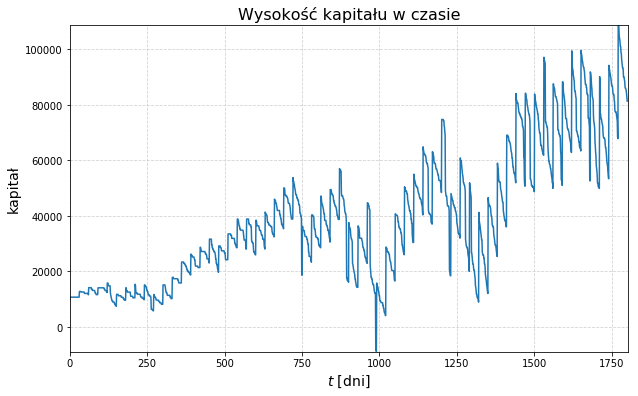

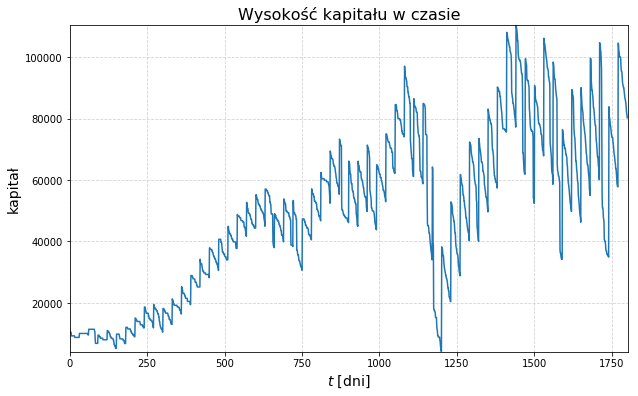

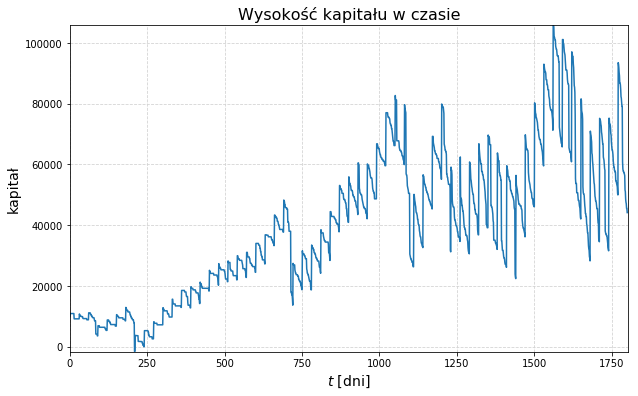

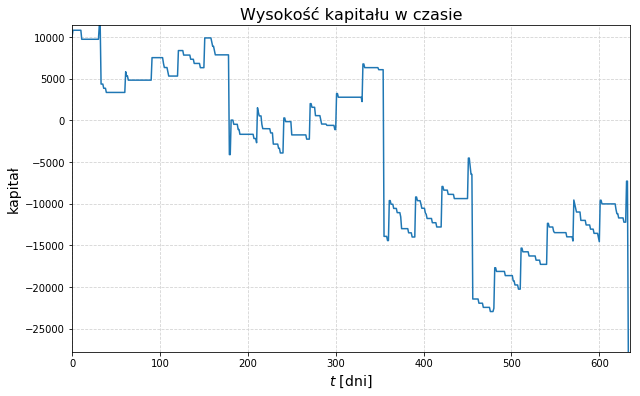

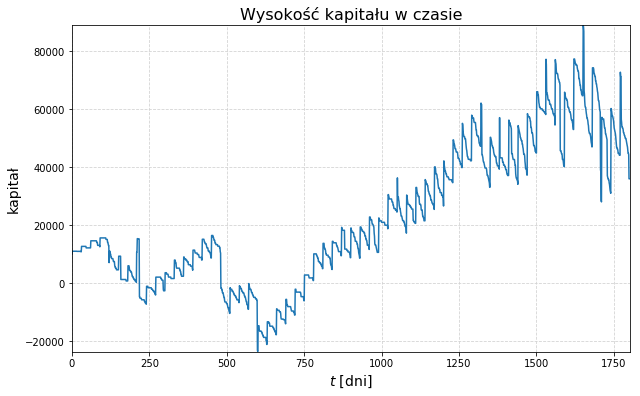

In [58]:
for i in range(5):
    symulacja = symulacja_firma(1800)
    plt.figure(figsize = (10,6))
    plt.plot(list(range(len(symulacja))), symulacja)
    plt.xlim(0,len(symulacja)+1) 
    plt.ylim(min(symulacja), max(symulacja))
    plt.grid(color='lightgray', ls='--')
    plt.xlabel("$t$ [dni]", fontsize=14)
    plt.ylabel("kapitał", fontsize=14)
    plt.title("Wysokość kapitału w czasie", fontsize=16)
    plt.show()

Na 4 wykresie możemy zaobserwować bankructwo naszej firmy. W pozostałych przypadkach nawet kiedy spadamy poniżej zera firma jest w stanie wyjść z debetu.

---

## Animacja 

In [62]:
def gif_symulacja(t):
    
    filenames = []
    images = []
    
    dt = t//10
    lista = list(range(dt,t+1,dt))
    symulacja = symulacja_firma(t)
    
    for i in lista:
        if len(symulacja)<i:
            break
        else:
            plt.plot(list(range(len(symulacja[:i]))), symulacja[:i], 'maroon')
            plt.xlim(0,len(symulacja)+1) 
            plt.ylim(min(symulacja), max(symulacja))
            plt.grid(color='lightgray', ls='--')
            plt.xlabel("$t$ [dni]", fontsize=14)
            plt.ylabel("kapitał", fontsize=14)
            plt.title("Wysokość kapitału w czasie", fontsize=16)
            nazwa = 'wykres' + str(i) + '.png'
            filenames.append(nazwa)    
            plt.savefig(nazwa)
            plt.show()
    
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('symulacja.gif', images, fps=1) 

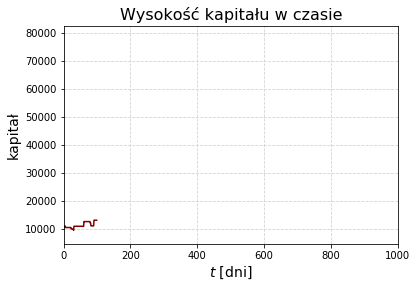

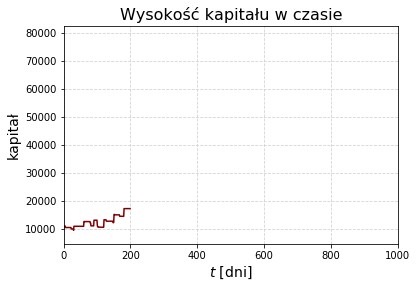

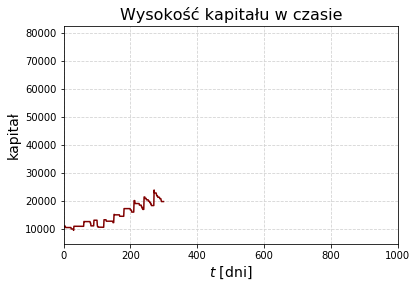

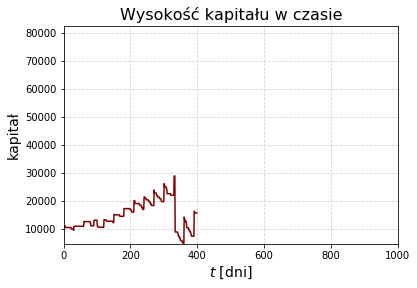

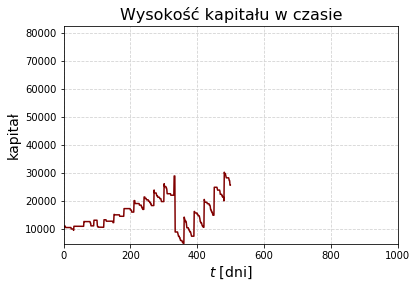

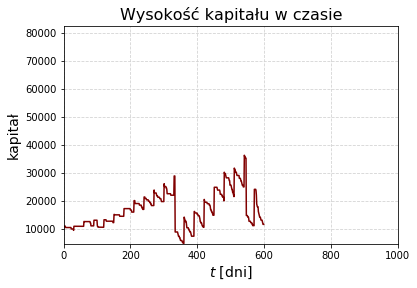

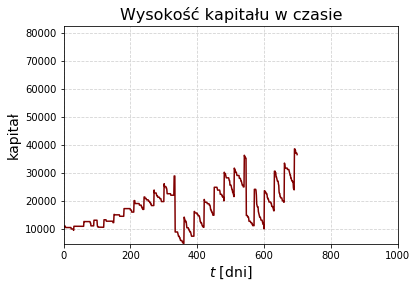

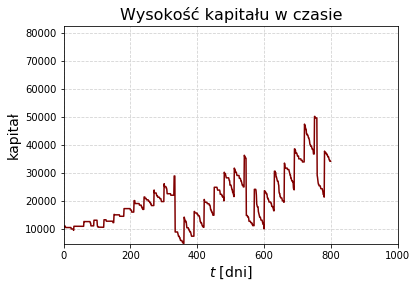

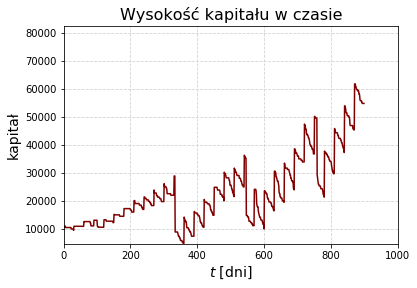

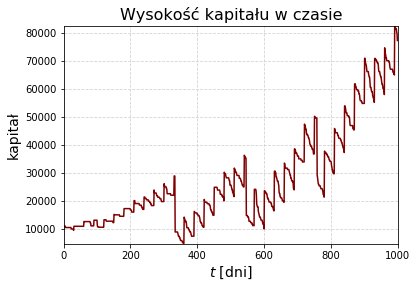

In [63]:
gif_symulacja(1000)

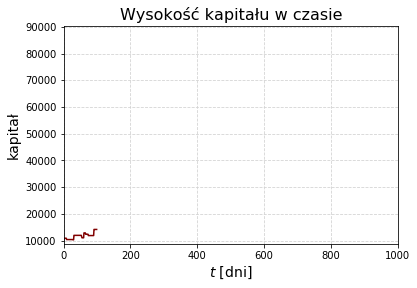

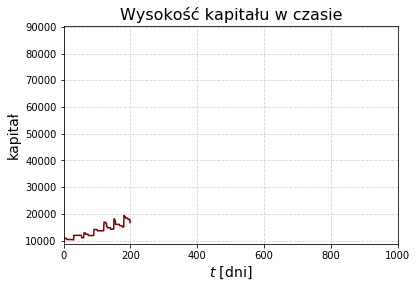

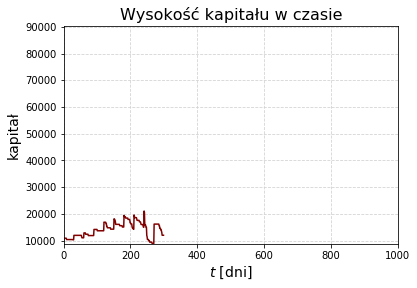

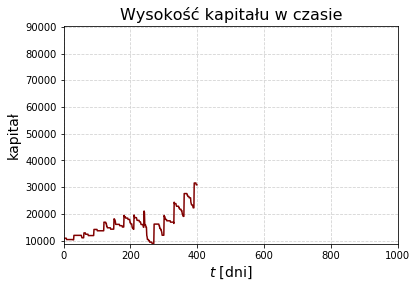

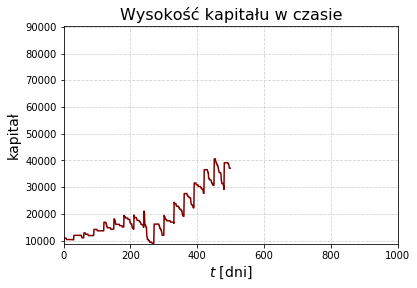

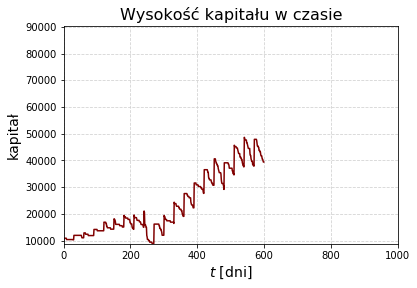

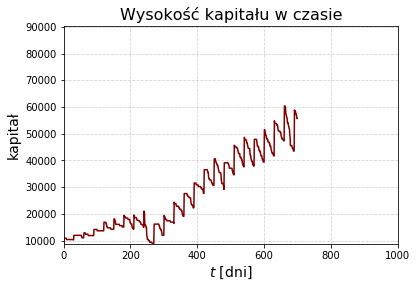

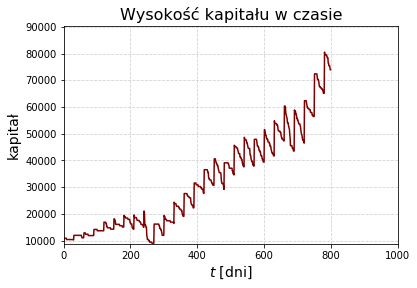

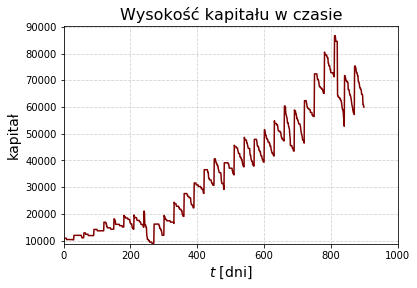

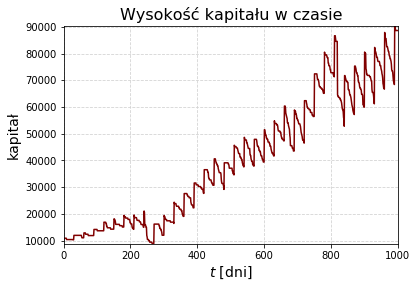

In [65]:
gif_symulacja(1000)

---

## Analizy

#### Prawdopodobieństwo bankructwa w czasie 5 lat dla przyjętych przez nas parametrów.

In [66]:
t = 1800
bankructwo = 0
for i in range(100):
    if len(symulacja_firma(t)) < t:
            bankructwo += 1
print(bankructwo/100)

0.13


#### Prawdopodobieństwo bankructwa w ciągu 10 lat dla przyjętych przez nas parametrów.

In [67]:
t = 3600
bankructwo = 0
for i in range(100):
    if len(symulacja_firma(t)) < t:
            bankructwo += 1
print(bankructwo/100)

0.13


#### Średni czas po jakim nasz dyrektor zostanie milionerem (nie dłużej niż 10 lat).

In [87]:
t = 3600
lista_t = []
for i in range(100):
    symulacja = symulacja_firma(t)
    for j in range(len(symulacja)):
        if symulacja[j] >= 1000000:
            lista_t.append(j)
print(np.mean(lista_t))

nan


Możemy wywnioskować, że dla przyjętych przez nas parametrów podanych wcześniej, dyrektor nie zostanie milionerem w przeciągu 10 lat.

A co jeśli zwiększymy początkowy kapitał do 100000?

In [88]:
t = 3600
lista_t = []
for i in range(100):
    symulacja = symulacja_firma(t, k0 = 100000)
    for j in range(len(symulacja)):
        if symulacja[j] >= 1000000:
            lista_t.append(j)
print(np.mean(lista_t))

nan


Wnioskujemy więc, że nawet zaczynając z kapitałem początkowym równym 100000 zł, nasz dyrektor nie będzie w stanie zostać milionerem w przeciągu 10 lat.

#### Oczekiwane roczne kapitały w przeciągu 5 lat

Przedstawimy teraz oczekiwane roczne kapitały:
- dla przyjętych przez nas parametrów <br>
- jeśli zwiększymy ceny polis o 20zł miesięcznie

In [74]:
t = 1800
lista_kapitalow1 = np.zeros(5)
lista_kapitalow2 = np.zeros(5)
for i in range(100):
    symulacja1 = symulacja_firma(t)
    symulacja2 = symulacja_firma(t, c_oc=80, c_ac=60)
    if len(symulacja1) < t+1:
        symulacja1[len(symulacja1):t+1] = [0] * (t+1-len(symulacja1))
    if len(symulacja2) < t+1:
        symulacja2[len(symulacja2):t+1] = [0] * (t+1-len(symulacja2))
    for j in range(5):
        lista_kapitalow1[j] += sum(symulacja1[j*12+1:(j+1)*12+1])/100
        lista_kapitalow2[j] += sum(symulacja2[j*12+1:(j+1)*12+1])/100

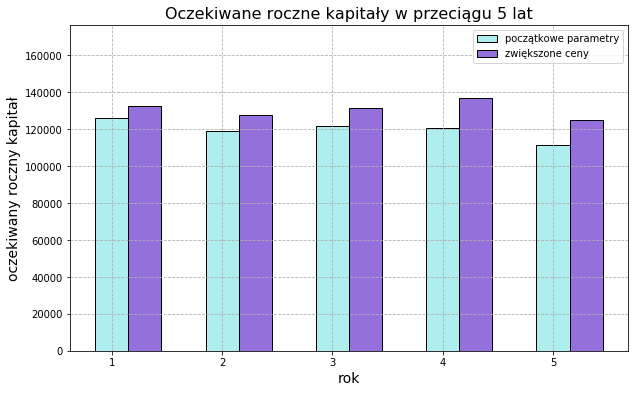

In [92]:
barWidth = 0.3
br1 = np.arange(len(lista_kapitalow1))
br2 = [x + barWidth for x in br1]

plt.figure(figsize = (10,6))
plt.grid(ls='--')
plt.bar(br1, lista_kapitalow1, width = barWidth, color = 'paleturquoise', edgecolor = 'black', label='początkowe parametry')
plt.bar(br2, lista_kapitalow2, width = barWidth, color = 'mediumpurple', edgecolor = 'black', label='zwiększone ceny')
plt.xticks([0,1,2,3,4], ['1','2','3','4','5'])
plt.ylim(0,max(lista_kapitalow2)+40000)
plt.xlabel("rok", fontsize=14)
plt.ylabel("oczekiwany roczny kapitał", fontsize=14)
plt.title("Oczekiwane roczne kapitały w przeciągu 5 lat", fontsize=16)
plt.legend()
plt.show()

Możemy zauważyć, że podnosząc ceny za polisy OC i AC o 20zł różnica w średnich rocznych kapitałach jest stosunkowo niska, maksymalnie wynosi ona 16tys. zł. 

#### Prawdopodobieństwo bankructwa w ciągu 5 lat dla innych parametrów.

Zbadamy teraz prawdopodobieństwo bankructwa w ciągu 5 lat w zależności od parametrów: <br>
$k_{0}$ - kapitał początkowy <br>
$n$ - początkowa ilość sprzedanych polis OC <br>
$c_{oc}$ - cena OC <br>

Parametry, których nie zmieniamy to: <br>
$c_{ac}$ - cena AC - 40zł<br>
$m$ - ilość sprzedanych polis AC <br>
$m_{oc}$ - popyt OC - 1000 <br>
$m_{ac}$ - popyt AC - 1000 <br>
$s_{oc}$ - stała popyt OC - 10 <br>
$M_{ac}$ - stała związana z ceną AC - 10 <br>
$ \mu $ - nakład na marketing - 10% z kapitału <br>
$n_{0}$ - ustalony parametr - 1/5 <br>
$\lambda_{w}$ - ustalony parametr - 500 <br>
$t_{V}$ - ustalony parametr - 0 <br>
przychód, zysk - miesięczne <br>
kapitał, koszty - dzienne <br>

#### dla $ k_{0} $

In [68]:
t = 1800
lista_k0 = [10**i for i in range(1,6)]
lista_bankructwo_od_k0 = []

for k in lista_k0:   
    bankructwo = 0
    for i in range(100):
        if len(symulacja_firma(t, k0 = k)) < t:
            bankructwo += 1
    lista_bankructwo_od_k0.append(bankructwo/100)

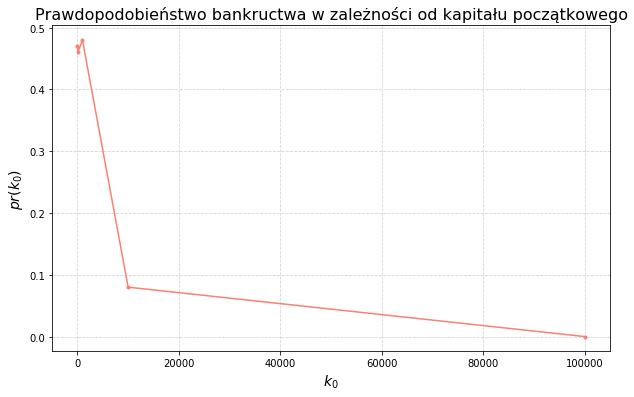

In [69]:
plt.figure(figsize = (10,6))
plt.plot(lista_k0, lista_bankructwo_od_k0, 'salmon', marker='.')
plt.grid(color='lightgray', ls='--')
plt.xlabel("$k_{0}$", fontsize=14)
plt.ylabel("$pr(k_{0})$", fontsize=14)
plt.title("Prawdopodobieństwo bankructwa w zależności od kapitału początkowego", fontsize=16)
plt.show()

Im większy kapitał początkowy, tym mniejsze prawdopodobienstwo ruiny firmy z przyjętymi przez nas pozostałymi parametrami. Dla $k_{0} \in [10, 1000] $ prawdopodobieństwo bankructwa w przeciągu 5 lat jest wysokie, wynosi około 50%. Możemy zauważyć, że w przypadku $k_{0}$ równego 100000 prawdopodobieństwo jest praktycznie zerowe.

#### dla $ n $

In [96]:
t = 1800
lista_n = list(range(1,102,10))
lista_bankructwo_od_n = []

for k in lista_n:   
    bankructwo = 0
    for i in range(100):
        if len(symulacja_firma(t, n=k)) < t:
            bankructwo += 1
    lista_bankructwo_od_n.append(bankructwo/100)

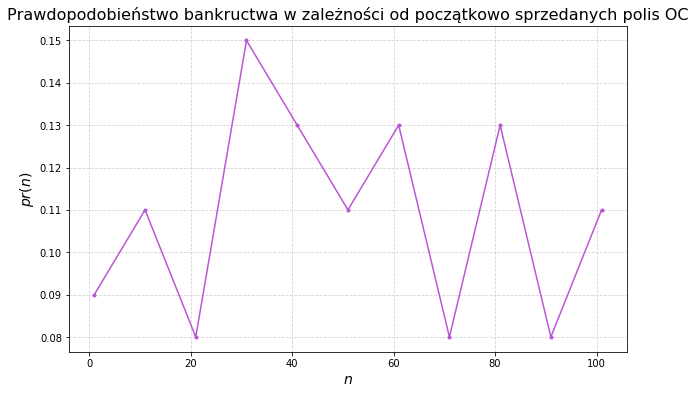

In [97]:
plt.figure(figsize = (10,6))
plt.plot(lista_n, lista_bankructwo_od_n, 'mediumorchid', marker='.')
plt.grid(color='lightgray', ls='--')
plt.xlabel("$n$", fontsize=14)
plt.ylabel("$pr(n)$", fontsize=14)
plt.title("Prawdopodobieństwo bankructwa w zależności od początkowo sprzedanych polis OC", fontsize=16)
plt.show()

Prawdopodobieństwo bankructwa firmy z przyjętymi przez nas parametrami w zależności od początkowo sprzedanych polis OC oscyluje pomiędzy 8% a 15%. Braliśmy pod uwagę $ n \in [1,100]$. Możemy stwierdzić, że ilość początkowo sprzedanych polis nie ma zbyt dużego wpływu na prawdopodobieństwo bankructwa.

#### dla $ c_{OC} $

In [72]:
t = 1800
lista_c_oc = list(range(20,101,20))
lista_bankructwo_od_c_oc = []

for c in lista_c_oc:   
    bankructwo = 0
    for i in range(100):
        if len(symulacja_firma(t, c_oc =c)) < t:
            bankructwo += 1
    lista_bankructwo_od_c_oc.append(bankructwo/100)

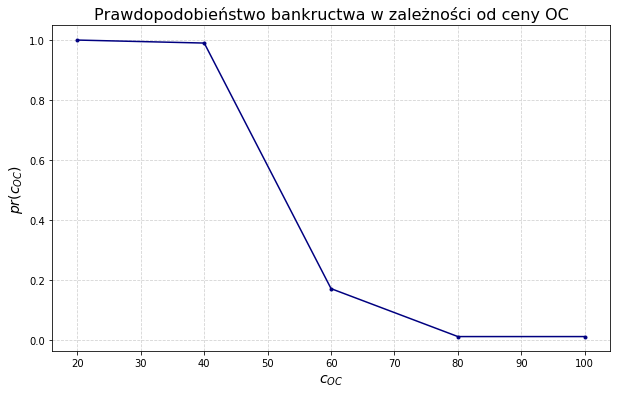

In [73]:
plt.figure(figsize = (10,6))
plt.plot(lista_c_oc, lista_bankructwo_od_c_oc, 'navy', marker='.')
plt.grid(color='lightgray', ls='--')
plt.xlabel("$c_{OC}$", fontsize=14)
plt.ylabel("$pr(c_{OC})$", fontsize=14)
plt.title("Prawdopodobieństwo bankructwa w zależności od ceny OC", fontsize=16)
plt.show()

Możemy wywnioskować, że dla $c_{oc} \in [20,40]$ prawdopodobieństwo bankructwa w przeciągu 5 lat jest prawie pewne. Dla $c_{oc} \in [40,80]$ zaczyna ono spadać, a dla ceny polisy OC powyżej 80 jest praktycznie zerowe.